In [1]:
# pip install jax
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/chaotic\ cortex

Mounted at /content/drive
/content/drive/My Drive/chaotic cortex


In [2]:
from pathlib import Path
import time
import jax.numpy as jnp
import matplotlib.pyplot as plt

exec(open("functions.py").read())

In [3]:
%ls -al /content/drive/My\ Drive/chaotic\ cortex/500_0.8_4_2-8_300/

total 8
drwx------ 2 root root 4096 Aug 30 10:02 1693389776/
drwx------ 2 root root 4096 Aug 31 04:55 1693457706/


In [4]:
# set basic parameters and subdirectory
part_n = 300##500
e_part_r = 0.8
e_mean = 4
ei_std_s = [2, 8]
short_interval_len = 300
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}_".format(ei_std_s[0],
                                        ei_std_s[1])
                + "{:n}/".format(short_interval_len))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1692953915#1693457706#round(time.time())
subdirectory = subdirectory + "{:n}".format(seed) + "/"
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
300_0.8_4_2-8_300/1692953915/


In [ ]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_n_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 5##15
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          connectivity_s)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = round(part_n / 100)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
ext_connectivity_n = 3##2
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         ext_connectivity_n,
                                                         key)
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_ext_gen, ext_part_n, unscaled_ext_mean, unscaled_ext_std, ext_sub_part_r_s,
          ext_sub_part_n_s,
          ext_connectivity_n,
          ext_connectivity_s)

phase_n = 3##2
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.4, 0.8]), 1) # or (wave_n, ext_part_n) arrays so different ext parts have different amps
freq_s = jnp.full(amp_s.shape, 0.)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

initial_condition_mean = jnp.full((part_n, ), 0)
initial_condition_cov = jnp.identity(part_n)
initial_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
initial_condition_n_free = initial_condition_n * ext_condition_n
[initial_condition_s, key] = initial_condition_s_generator(part_n, initial_condition_mean, initial_condition_cov, initial_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          initial_condition_mean, initial_condition_cov,
          initial_condition_n,
          ext_condition_n, initial_condition_n_free,
          initial_condition_s)

condition_s = jnp.asarray([1, 1])
short_interval_n_in_long_s = jnp.asarray([1, 2])
short_interval_n = jnp.sum(short_interval_n_in_long_s)
tot_interval = jnp.asarray([0, short_interval_n * short_interval_len])
time_interval_info = [tot_interval, condition_s, short_interval_n_in_long_s]
condition_s_free = jnp.asarray([0, 0])
time_interval_info_free = [tot_interval, condition_s_free, short_interval_n_in_long_s]
jnp.savez(subdirectory + "parameter_s_6.npz",
          condition_s, short_interval_n_in_long_s,
          short_interval_n, tot_interval, time_interval_info,
          condition_s_free, time_interval_info_free)

resolution = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          resolution)

In [5]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_ext_gen, ext_part_n, unscaled_ext_mean, unscaled_ext_std, ext_sub_part_r_s,
 ext_sub_part_n_s,
 ext_connectivity_n,
 ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[initial_condition_mean, initial_condition_cov,
 initial_condition_n,
 ext_condition_n, initial_condition_n_free,
 initial_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[condition_s, short_interval_n_in_long_s,
 short_interval_n, tot_interval, time_interval_info,
 condition_s_free, time_interval_info_free] = load_as_list(subdirectory + "parameter_s_6.npz")

[resolution] = load_as_list(subdirectory + "parameter_s_7.npz")

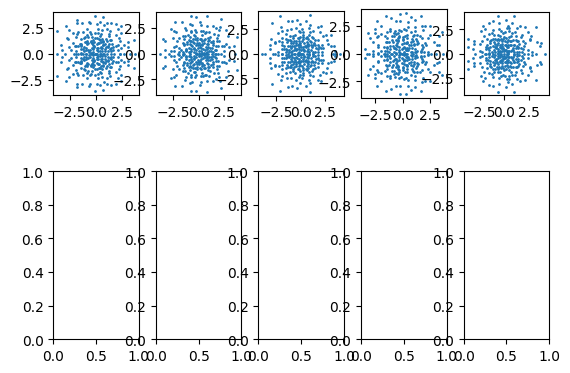

In [6]:
# plot spectra
[fig, subfig_s] = plt.subplots(max(int(connectivity_n)//5, 2), 5)
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[connectivity_idx // 5, connectivity_idx % 5].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[connectivity_idx // 5, connectivity_idx % 5].set_aspect('equal')

In [ ]:
# run and save stats
stat_s_free = network_stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], initial_condition_s,
                                 time_interval_info_free, resolution)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

stat_s = network_stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, initial_condition_s[::ext_condition_n],
                            time_interval_info, resolution)
np.savez_compressed(subdirectory + "stats.npz", *stat_s)

[15, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[20, 'initial_condition_n']
[3, 'short_interval_n']
['mean_s', 'cov_s', 'short_pr_pca_s', 'long_pr_pca_s', 'mean_traj_s']
1693457874
1693457996,0
1693458115,1
1693458233,2
1693458351,3
1693458468,4
1693458585,5
1693458703,6
1693458821,7
1693458939,8
1693459057,9
1693459174,10
1693459293,11
1693459412,12
1693459529,13
1693459648,14


In [7]:
# load stats
stat_s_free = load_as_list(subdirectory + "stats_free.npz")
stat_s = load_as_list(subdirectory + "stats.npz")

preliminary plotting

In [8]:
# for later plotting
import matplotlib.patches as mpatches
color_s = plt.rcParams['axes.prop_cycle'].by_key()['color']

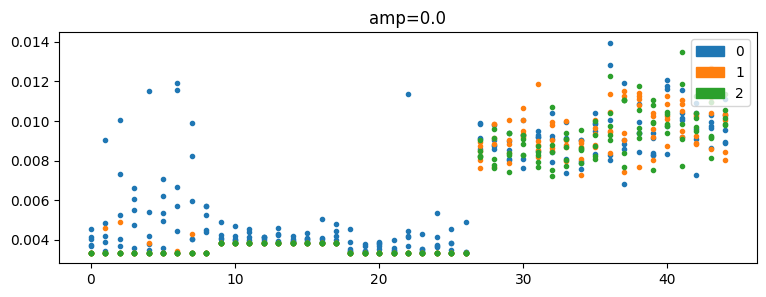

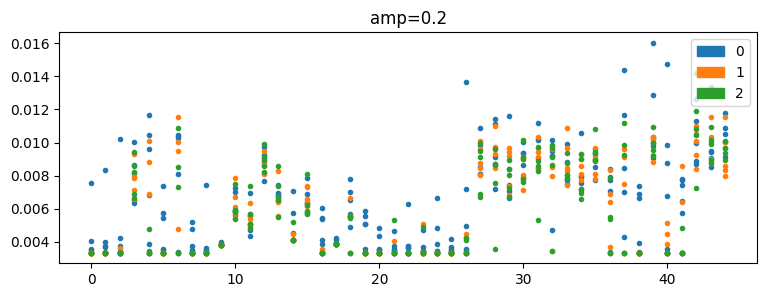

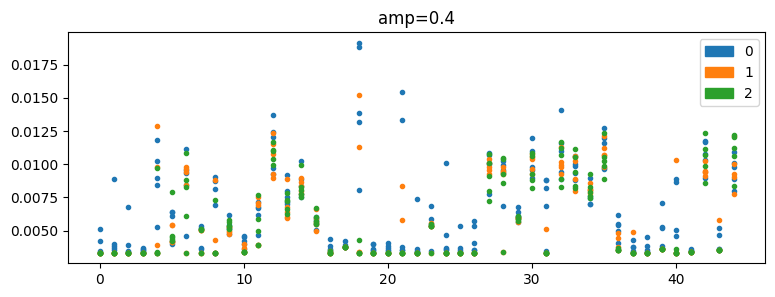

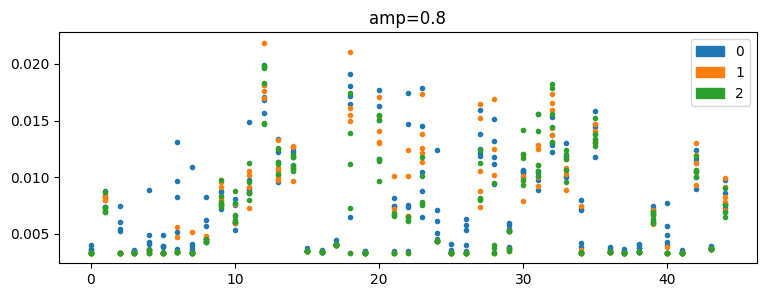

In [9]:
handle_s = [mpatches.Patch(color=color_s[short_interval_idx], label=short_interval_idx)
for short_interval_idx in range(short_interval_n)]

cov_s_free_reshaped = stat_s_free[2].reshape((connectivity_n, 1,
                                              ext_connectivity_n, phase_n, initial_condition_n,
                                              short_interval_n))
plt.figure()
plt.title("amp={}".format(0.0))
for short_interval_idx in range(short_interval_n):
  for initial_condition_idx in range(initial_condition_n):
    plt.plot(cov_s_free_reshaped[:, :, :, :, initial_condition_idx, short_interval_idx].flatten(),
              label = short_interval_idx,
              marker='.', linestyle='', color = color_s[short_interval_idx])
plt.legend(handles=handle_s, loc="upper right")
fig = plt.gcf()
fig.set_size_inches(9, 3)

for wave_idx in range(wave_s.shape[0]):
  plt.figure()
  plt.title("amp={:n}".format(wave_s[wave_idx, 0]))
  for short_interval_idx in range(jnp.sum(short_interval_n_in_long_s)):
    for initial_condition_idx in range(initial_condition_n):
      plt.plot(stat_s[2][:, wave_idx, :, :, initial_condition_idx, short_interval_idx].flatten(),
             label = short_interval_idx,
             marker='.', linestyle='', color = color_s[short_interval_idx])
  plt.legend(handles=handle_s, loc="upper right")
  fig = plt.gcf()
  fig.set_size_inches(9, 3)

In [10]:
idx_s = jnp.transpose(jnp.asarray([[1,1,1],[0,0,1],[1,0,0],[1,0,1],[1,0,2],[1,1,0],[1,1,1],[1,1,2],[2,0,2],[2,1,2]])) # [0,2,2] [2,2,0]
jnp.savez(subdirectory + "strange_indices.npz",
          idx_s)

In [20]:
[idx_s] = load_as_list(subdirectory + "strange_indices.npz")

In [11]:
long_tr_free = jnp.concatenate(jnp.transpose(stat_s_free[4][idx_s[0],0,0,0,:,:,::resolution],(2,0,1,3)),axis = -1)
long_tr_strong = jnp.concatenate(jnp.transpose(stat_s[4][idx_s[0],2,idx_s[1],idx_s[2],:,:,::resolution],(2,0,1,3)),axis = -1)

last_tr_free = stat_s_free[4][idx_s[0],0,0,0,:,-1]
last_tr_strong = stat_s[4][idx_s[0],2,idx_s[1],idx_s[2],:,-1]

print(idx_s.shape[1])

10


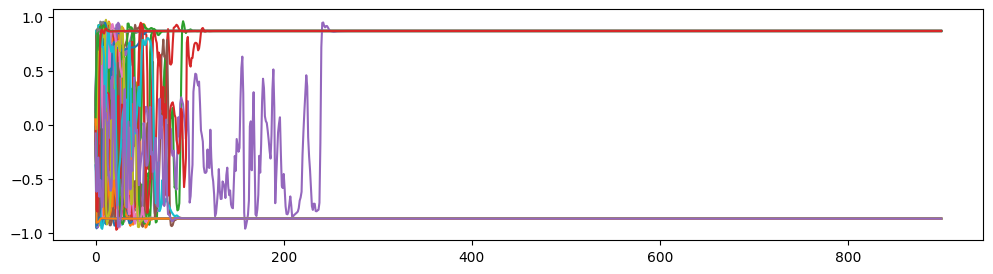

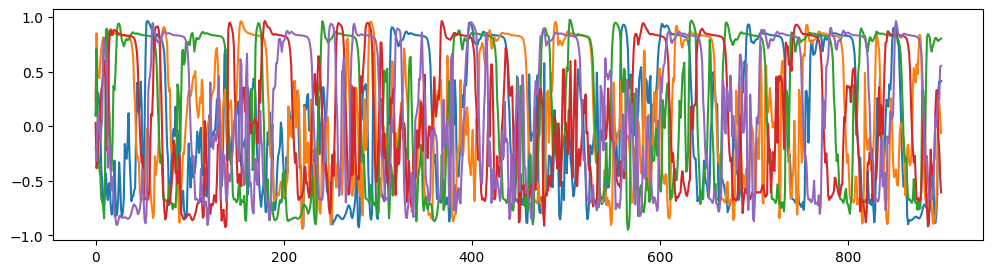

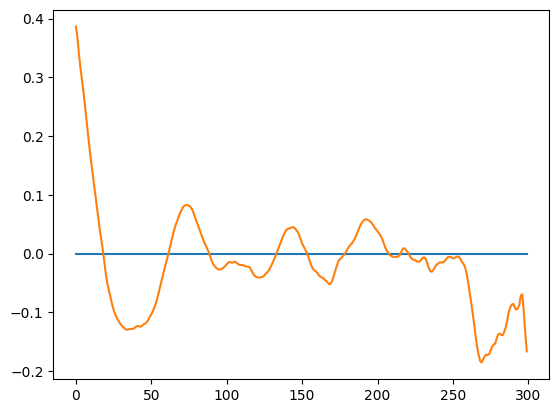

In [12]:
idx = -1

for idx2 in range(initial_condition_n_free):
  plt.plot(long_tr_free[idx, idx2])
fig = plt.gcf()
fig.set_size_inches(12, 3)

plt.figure()
for idx2 in range(initial_condition_n):
  plt.plot(long_tr_strong[idx, idx2])
fig = plt.gcf()
fig.set_size_inches(12, 3)

lag_s = jnp.arange(short_interval_len)
cor_free = jnp.mean(matched_correlation_fct(last_tr_free[idx], last_tr_free[idx])[..., lag_s * resolution], axis = 0)
cor = jnp.mean(matched_correlation_fct(last_tr_strong[idx], last_tr_strong[idx])[..., lag_s * resolution], axis = 0)

plt.figure()
plt.plot(lag_s, cor_free)
plt.plot(lag_s, cor)